In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import dask
from dask.diagnostics import progress
import fsspec
import glob
from matplotlib import pyplot as plt
import gc
import matplotlib as mpl
from scipy.stats import norm

from params import allnames, experiment_ids, variables
from myfunctions import drop_all_bounds, open_dset, open_delayed, get_lat_name, global_mean, global_mean_60s, snotel_pipe, load_global
from myfunctions import droughtindx, get_swei
from myfunctions import process_variable
## 
xr.set_options(display_style='html')
plt.style.use('./science.mplstyle')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False


/tmp/ipykernel_52410/2900596171.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [3]:
snoteldir = '/global/cfs/cdirs/m4099/fate-of-snotel/snoteldata/'
snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')

In [3]:
df_snw, snw_mean, snw_anom, snw_monthly, snw_snotel  = load_global('snw','LImon',experiment_ids,rm_arc = True)
#df_tas, tas_mean, tas_anom, tas_monthly, tas_snotel  = load_global('tas','Amon', experiment_ids, rm_arc = True)
#df_pr, pr_mean, pr_anom, pr_monthly, pr_snotel  = load_global('pr','Amon',experiment_ids, rm_arc = True)

/global/homes/c/cowherd/.conda/envs/e3smeval/lib/python3.10/site-packages/intake_esm/_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:
100%|██████████| 9/9 [03:13<00:00, 21.49s/it]

[                                        ] | 1% Completed | 110.26 ms

[########################################] | 100% Completed | 9.71 ss
[########################################] | 100% Completed | 11.15 s
[########################################] | 100% Completed | 12.70 s


In [2]:
# import numpy as np
import xarray as xr
import rioxarray as rxr
import intake
import pandas as pd
from params import allnames
import glob 
import noresmfunctions as fct
from collections import defaultdict
import requests
import xml.etree.ElementTree as ET
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import dask
from dask.diagnostics import progress
import fsspec
import glob
from matplotlib import pyplot as plt
import gc
import matplotlib as mpl
from scipy.stats import norm
from myfunctions import process_variable


from params import snotelmeta


#for variable in ['snw']:
#    for experiment_id in ['historical']:
#        process_variable(variable, experiment_id)


/tmp/ipykernel_44228/1661907014.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [19]:
import numpy as np
import xarray as xr
import rioxarray as rxr
import intake
import pandas as pd
from params import allnames
import glob 
import noresmfunctions as fct
from collections import defaultdict
import requests
import xml.etree.ElementTree as ET
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import dask
from dask.diagnostics import progress
import fsspec
import glob
from matplotlib import pyplot as plt
import gc
import matplotlib as mpl
from scipy.stats import norm

from params import snotelmeta

var = 'snw'
experiment = 'ssp245'
experiment_ids = ['historical', 'ssp245', 'ssp585']
years = {'historical': [1850,2014],
         'ssp245':[2015,2099],
         'ssp585':[2015,2099]}
table_ids = {'tas':'Amon', 
             'pr': 'Amon',
             'snw':'LImon'}
labels =  {'snw':'SWE [kg m$^{-2}$]', 
             'pr': 'Precip [kg $d^{-1}$]',
             'tas':' Temp [K]'}
variables = ['tas','pr','snw']
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

add_colorbar = True
label = labels[var]
table_id = table_ids[var]  
starty = years[experiment][0]
endy = years[experiment][1]
cat = col.search(source_id=allnames, table_id = table_id, experiment_id=[experiment], variable_id=var)
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True,}, )
# metadata of the historical run:
_d2 = pd.Series(["calendar",
                 "branch_time_in_parent", #"parent_activity_id", "parent_experiment_id",	"parent_mip_era",
                 "parent_source_id",#"parent_sub_experiment_id", 
                 "parent_time_units",# "parent_variant_label"
                  ])
for i in dset_dict.keys():
    _data = []
    _names =[]
    _data.append(dset_dict[i].time.to_index().calendar)
    for k, v in dset_dict[i].attrs.items():

        if 'parent_time_units' in k or 'branch_time_in_parent' in k or 'parent_source_id' in k:
            _data.append(v)
            _names.append(k)
    _d2 = pd.concat([_d2,   pd.Series(_data)], axis=1)
    _d2.rename(columns={1:i.split('.')[2]}, inplace=True)
    _d2.rename(columns={0:i.split('.')[2]}, inplace=True)

_d2.dropna(how='all', axis=1, inplace=True)

tmp = np.where(['CSM2' in val for val in list(dset_dict.keys())])
tmp = [int(val) for val in tmp]
base_key = list(dset_dict.keys())[tmp[0]]

ds = dset_dict[base_key]

_month = ds[var].groupby('time.month').mean('time', keep_attrs = True)
_jan  = _month.sel(month = 1)

year_range = range(starty, endy+1)

# create dictionary for reggridded data
ds_gridded_dict = dict()

# Read in the output grid from NorESM
ds_out = dset_dict[base_key].isel(member_id = 0)
ds_out = ds_out.sel(time = ds_out.time.dt.year.isin(year_range)).squeeze()
standard_cal = ds_out['time']

counter = 0
for keys in dset_dict.keys():
    amon = keys.split('.')[-2]
    model = keys.split('.')[2]
    if model in allnames:
        try:
            # select where data should be saved
            filename = '{}_{}-{}01_{}12.nc'.format(var, model,starty, endy)
            savepath = '/global/cfs/cdirs/e3sm/cowherd/data/'.format(model)
            nc_out = savepath + filename
            files = glob.glob(nc_out)

            # Input data from CMIP6 model to be regridded
            ds_in = dset_dict[keys].isel(member_id = 0)
            ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()

            # they may not be on the same calendar and that's ok
            if len(ds_in['time']) == len(standard_cal):
                ds_in['time'] = standard_cal
            else:
                ds_in['time'] = standard_cal[1:]

            # Regrid data
            ds_in_regrid = fct.regrid_data(ds_in, ds_out)

            # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
            ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
            ds_in_regrid = ds_in_regrid.reset_coords(names=['time_bnds', ], drop=True)

            # create dataset with all models
            ds_gridded_dict[model] = ds_in_regrid

            if nc_out in files:
                print('{} is downloaded'.format(nc_out))
                counter += 1
                print('Have regridded in total: {:} files'.format(str(counter)))

            else:    
                # Save to netcdf file
                try:
                    ds_in_regrid.to_netcdf(nc_out)
                    print('file written: {}'.format(nc_out))
                except:
                    print('could not write {}'.format(nc_out))
        except:
            print(model)
_ds = list(ds_gridded_dict.values())
_coord = list(ds_gridded_dict.keys())
ds_cmip = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'model'})
ds_cmip = ds_cmip.drop('bnds')
#ds_cmip[var].attrs

ds_cmip[var+'_season_mean'] = ds_cmip[var].groupby('time.season').mean('time', keep_attrs=True)
ds_cmip[var+'_model_mean'] = ds_cmip[var].groupby('time').mean('model', keep_attrs=True, skipna = True)
ds_cmip[var+'_season_model_mean'] = ds_cmip[var+'_season_mean'].mean('model', keep_attrs=True, skipna = True)
ds_cmip[var+'_season_model_std']  = ds_cmip[var+'_season_mean'].std('model', keep_attrs=True, skipna = True)
nc_out = '/global/cfs/cdirs/e3sm/cowherd/data/{}_model_mean_{}.nc'.format(var,experiment)
#ds_cmip[var+'_model_mean'].to_netcdf(nc_out)
#print('wrote', nc_out)
ds_cmip['snw_model_mean'].to_netcdf('/global/cfs/cdirs/e3sm/cowherd/data/snw_model_mean_ssp256.nc')

'''
for model in ds_cmip.model.values:
    fig,_,_ = fct.plt_spatial_seasonal_mean(ds_cmip[var+'_season_mean'].sel(model=model),var, title='{} MEAN ({} - {})'.format(model,starty, endy))
    plt.savefig('./figures/{}_{}_seasonal_mean.jpg'.format(model,var))
'''
'''
fig, axs, im = fct.plt_spatial_seasonal_mean(ds_cmip[var+'_season_model_mean'], var, add_colorbar = False, title='Inter-Model Mean {}, {}'.format(var,experiment))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(label), weight='bold')
plt.tight_layout()
plt.savefig('./figures/{}_{}_seasonal_mean.jpg'.format(model,var))
'''



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/tmp/ipykernel_44228/3618575767.py:47: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True,}, )


snw True
/global/cfs/cdirs/e3sm/cowherd/data/snw_MRI-ESM2-0-201501_209912.nc is downloaded
Have regridded in total: 1 files
snw True
/global/cfs/cdirs/e3sm/cowherd/data/snw_ACCESS-CM2-201501_209912.nc is downloaded
Have regridded in total: 2 files
snw True
/global/cfs/cdirs/e3sm/cowherd/data/snw_GFDL-ESM4-201501_209912.nc is downloaded
Have regridded in total: 3 files
snw True
/global/cfs/cdirs/e3sm/cowherd/data/snw_BCC-CSM2-MR-201501_209912.nc is downloaded
Have regridded in total: 4 files
snw True
/global/cfs/cdirs/e3sm/cowherd/data/snw_GFDL-CM4-201501_209912.nc is downloaded
Have regridded in total: 5 files
snw True
/global/cfs/cdirs/e3sm/cowherd/data/snw_MIROC6-201501_209912.nc is downloaded
Have regridded in total: 6 files
snw True
/global/cfs/cdirs/e3sm/cowherd/data/snw_CESM2-WACCM-201501_209912.nc is downloaded
Have regridded in total: 7 files
snw True
/global/cfs/cdirs/e3sm/cowherd/data/snw_UKESM1-0-LL-201501_209912.nc is downloaded
Have regridded in total: 8 files


/global/homes/c/cowherd/.conda/envs/e3smeval/lib/python3.10/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


snw True
IPSL-CM6A-LR



KeyboardInterrupt



In [10]:
import numpy as np
import xarray as xr
import rioxarray as rxr
import intake
import pandas as pd
from params import allnames
import glob 
import noresmfunctions as fct
from collections import defaultdict
import requests
import xml.etree.ElementTree as ET
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import dask
from dask.diagnostics import progress
import fsspec
import glob
from matplotlib import pyplot as plt
import gc
import matplotlib as mpl
from scipy.stats import norm

from params import snotelmeta

var = 'snw'
experiment = 'ssp585'
experiment_ids = ['historical', 'ssp245', 'ssp585']
years = {'historical': [1850,2014],
         'ssp245':[2015,2099],
         'ssp585':[2015,2099]}
table_ids = {'tas':'Amon', 
             'pr': 'Amon',
             'snw':'LImon'}
labels =  {'snw':'SWE [kg m$^{-2}$]', 
             'pr': 'Precip [kg $d^{-1}$]',
             'tas':' Temp [K]'}
variables = ['tas','pr','snw']
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

add_colorbar = True
label = labels[var]
table_id = table_ids[var]  
starty = years[experiment][0]
endy = years[experiment][1]
cat = col.search(source_id=allnames, table_id = table_id, experiment_id=[experiment], variable_id=var)
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True,}, )
# metadata of the historical run:
_d2 = pd.Series(["calendar",
                 "branch_time_in_parent", #"parent_activity_id", "parent_experiment_id",	"parent_mip_era",
                 "parent_source_id",#"parent_sub_experiment_id", 
                 "parent_time_units",# "parent_variant_label"
                  ])
for i in dset_dict.keys():
    _data = []
    _names =[]
    _data.append(dset_dict[i].time.to_index().calendar)
    for k, v in dset_dict[i].attrs.items():

        if 'parent_time_units' in k or 'branch_time_in_parent' in k or 'parent_source_id' in k:
            _data.append(v)
            _names.append(k)
    _d2 = pd.concat([_d2,   pd.Series(_data)], axis=1)
    _d2.rename(columns={1:i.split('.')[2]}, inplace=True)
    _d2.rename(columns={0:i.split('.')[2]}, inplace=True)

_d2.dropna(how='all', axis=1, inplace=True)

tmp = np.where(['CSM2' in val for val in list(dset_dict.keys())])
tmp = [int(val) for val in tmp]
base_key = list(dset_dict.keys())[tmp[0]]

ds = dset_dict[base_key]

_month = ds[var].groupby('time.month').mean('time', keep_attrs = True)
_jan  = _month.sel(month = 1)

year_range = range(starty, endy+1)

# create dictionary for reggridded data
ds_gridded_dict = dict()

# Read in the output grid from NorESM
ds_out = dset_dict[base_key].isel(member_id = 0)
ds_out = ds_out.sel(time = ds_out.time.dt.year.isin(year_range)).squeeze()
standard_cal = ds_out['time']

counter = 0
for keys in dset_dict.keys():
    amon = keys.split('.')[-2]
    model = keys.split('.')[2]
    if model in allnames:
        try:
            # select where data should be saved
            filename = '{}_{}-{}01_{}12.nc'.format(var, model,starty, endy)
            savepath = '/global/cfs/cdirs/e3sm/cowherd/data/'.format(model)
            nc_out = savepath + filename
            files = glob.glob(nc_out)

            # Input data from CMIP6 model to be regridded
            ds_in = dset_dict[keys].isel(member_id = 0)
            ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()

            # they may not be on the same calendar and that's ok
            if len(ds_in['time']) == len(standard_cal):
                ds_in['time'] = standard_cal
            else:
                ds_in['time'] = standard_cal[1:]

            # Regrid data
            ds_in_regrid = fct.regrid_data(ds_in, ds_out)

            # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
            ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
            ds_in_regrid = ds_in_regrid.reset_coords(names=['time_bnds', ], drop=True)

            # create dataset with all models
            ds_gridded_dict[model] = ds_in_regrid

            if nc_out in files:
                print('{} is downloaded'.format(nc_out))
                counter += 1
                print('Have regridded in total: {:} files'.format(str(counter)))

            else:    
                # Save to netcdf file
                try:
                    ds_in_regrid.to_netcdf(nc_out)
                    print('file written: {}'.format(nc_out))
                except:
                    print('could not write {}'.format(nc_out))
        except:
            print(model)
_ds = list(ds_gridded_dict.values())
_coord = list(ds_gridded_dict.keys())
ds_cmip = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'model'})
ds_cmip = ds_cmip.drop('bnds')
#ds_cmip[var].attrs

ds_cmip[var+'_season_mean'] = ds_cmip[var].groupby('time.season').mean('time', keep_attrs=True)
ds_cmip[var+'_model_mean'] = ds_cmip[var].groupby('time').mean('model', keep_attrs=True, skipna = True)
ds_cmip[var+'_season_model_mean'] = ds_cmip[var+'_season_mean'].mean('model', keep_attrs=True, skipna = True)
ds_cmip[var+'_season_model_std']  = ds_cmip[var+'_season_mean'].std('model', keep_attrs=True, skipna = True)
nc_out = '/global/cfs/cdirs/e3sm/cowherd/data/{}_model_mean_{}.nc'.format(var,experiment)
#ds_cmip[var+'_model_mean'].to_netcdf(nc_out)
#print('wrote', nc_out)
ds_cmip['snw_model_mean'].to_netcdf('/global/cfs/cdirs/e3sm/cowherd/data/snw_model_mean_ssp585.nc')

'''
for model in ds_cmip.model.values:
    fig,_,_ = fct.plt_spatial_seasonal_mean(ds_cmip[var+'_season_mean'].sel(model=model),var, title='{} MEAN ({} - {})'.format(model,starty, endy))
    plt.savefig('./figures/{}_{}_seasonal_mean.jpg'.format(model,var))
'''
'''
fig, axs, im = fct.plt_spatial_seasonal_mean(ds_cmip[var+'_season_model_mean'], var, add_colorbar = False, title='Inter-Model Mean {}, {}'.format(var,experiment))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(label), weight='bold')
plt.tight_layout()
plt.savefig('./figures/{}_{}_seasonal_mean.jpg'.format(model,var))
'''


Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x15551484b640>
Traceback (most recent call last):
  File "/global/homes/c/cowherd/.conda/envs/e3smeval/lib/python3.10/weakref.py", line 106, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [14]:
ds_cmip['snw_model_mean'][100,:,:].compute()


KeyboardInterrupt



In [15]:
ds_cmip['snw_model_mean'].to_netcdf('test_snw_hist.nc')


KeyboardInterrupt



In [18]:
ds_cmip.to_netcdf('/global/cfs/cdirs/e3sm/cowherd/snow.nc')

In [ ]:
print('hello')

In [4]:
tmp = ds_cmip.isel(model=2)
plt.plot(np.nanmean(tmp['snw'],axis = (1,2)))


NameError: name 'ds_cmip' is not defined

In [ ]:
ds_cmip.model

In [45]:
var = 'snw'
experiment = 'ssp245'
experiment_ids = ['historical', 'ssp245', 'ssp585']
years = {'historical': [1850,2014],
         'ssp245':[2015,2099],
         'ssp585':[2015,2099]}
table_ids = {'tas':'Amon', 
             'pr': 'Amon',
             'snw':'LImon'}
labels =  {'snw':'SWE [kg m$^{-2}$]', 
             'pr': 'Precip [kg $d^{-1}$]',
             'tas':' Temp [K]'}
variables = ['tas','pr','snw']
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

add_colorbar = True
label = labels[var]
table_id = table_ids[var]  
starty = years[experiment][0]
endy = years[experiment][1]
cat = col.search(source_id=allnames, table_id = table_id, experiment_id=[experiment], variable_id=var)
cat2 = cat.df.groupby('source_id').first()
dset_dict = cat2.to_dataset_dict(zarr_kwargs={'use_cftime':True,}, )
# metadata of the historical run:
_d2 = pd.Series(["calendar",
                 "branch_time_in_parent", #"parent_activity_id", "parent_experiment_id",	"parent_mip_era",
                 "parent_source_id",#"parent_sub_experiment_id", 
                 "parent_time_units",# "parent_variant_label"
                  ])
for i in dset_dict.keys():
    _data = []
    _names =[]
    _data.append(dset_dict[i].time.to_index().calendar)
    for k, v in dset_dict[i].attrs.items():

        if 'parent_time_units' in k or 'branch_time_in_parent' in k or 'parent_source_id' in k:
            _data.append(v)
            _names.append(k)
    _d2 = pd.concat([_d2,   pd.Series(_data)], axis=1)
    _d2.rename(columns={1:i.split('.')[2]}, inplace=True)
    _d2.rename(columns={0:i.split('.')[2]}, inplace=True)

_d2.dropna(how='all', axis=1, inplace=True)

tmp = np.where(['CSM2' in val for val in list(dset_dict.keys())])
tmp = [int(val) for val in tmp]
base_key = list(dset_dict.keys())[tmp[0]]

ds = dset_dict[base_key]

_month = ds[var].groupby('time.month').mean('time', keep_attrs = True)
_jan  = _month.sel(month = 1)

year_range = range(starty, endy+1)

# create dictionary for reggridded data
ds_gridded_dict = dict()

# Read in the output grid from NorESM
ds_out = dset_dict[base_key].isel(member_id = 0)
ds_out = ds_out.sel(time = ds_out.time.dt.year.isin(year_range)).squeeze()
standard_cal = ds_out['time']

counter = 0
for keys in dset_dict.keys():
    amon = keys.split('.')[-2]
    model = keys.split('.')[2]
    if model in allnames:
        try:
            # select where data should be saved
            filename = '{}_{}-{}01_{}12.nc'.format(var, model,starty, endy)
            savepath = '/global/cfs/cdirs/e3sm/cowherd/data/'.format(model)
            nc_out = savepath + filename
            files = glob.glob(nc_out)

            # Input data from CMIP6 model to be regridded
            ds_in = dset_dict[keys].isel(member_id = 0)
            ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()

            # they may not be on the same calendar and that's ok
            if len(ds_in['time']) == len(standard_cal):
                ds_in['time'] = standard_cal
            else:
                ds_in['time'] = standard_cal[1:]

            # Regrid data
            ds_in_regrid = fct.regrid_data(ds_in, ds_out)

            # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
            ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
            ds_in_regrid = ds_in_regrid.reset_coords(names=['time_bnds', ], drop=True)

            # create dataset with all models
            ds_gridded_dict[model] = ds_in_regrid

            if nc_out in files:
                print('{} is downloaded'.format(nc_out))
                counter += 1
                print('Have regridded in total: {:} files'.format(str(counter)))

            else:    
                # Save to netcdf file
                try:
                    ds_in_regrid.to_netcdf(nc_out)
                    print('file written: {}'.format(nc_out))
                except:
                    print('could not write {}'.format(nc_out))
        except:
            print(model)
_ds = list(ds_gridded_dict.values())
_coord = list(ds_gridded_dict.keys())
ds_cmip = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'model'})
ds_cmip = ds_cmip.drop('bnds')
#ds_cmip[var].attrs

ds_cmip[var+'_season_mean'] = ds_cmip[var].groupby('time.season').mean('time', keep_attrs=True)
ds_cmip[var+'_model_mean'] = ds_cmip[var].groupby('time').mean('model', keep_attrs=True, skipna = True)
ds_cmip[var+'_season_model_mean'] = ds_cmip[var+'_season_mean'].mean('model', keep_attrs=True, skipna = True)
ds_cmip[var+'_season_model_std']  = ds_cmip[var+'_season_mean'].std('model', keep_attrs=True, skipna = True)
nc_out = '/global/cfs/cdirs/e3sm/cowherd/data/{}_model_mean_{}.nc'.format(var,experiment)
ds_cmip[var+'_model_mean'].to_netcdf(nc_out)
print('wrote', nc_out)
ds_cmip['snw_model_mean'].to_netcdf('/global/cfs/cdirs/e3sm/cowherd/data/snw_model_mean_ssp245_test.nc')

'''
for model in ds_cmip.model.values:
    fig,_,_ = fct.plt_spatial_seasonal_mean(ds_cmip[var+'_season_mean'].sel(model=model),var, title='{} MEAN ({} - {})'.format(model,starty, endy))
    plt.savefig('./figures/{}_{}_seasonal_mean.jpg'.format(model,var))
'''

fig, axs, im = fct.plt_spatial_seasonal_mean(ds_cmip[var+'_season_model_mean'], var, add_colorbar = False, title='Inter-Model Mean {}, {}'.format(var,experiment))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(label), weight='bold')
plt.tight_layout()


AttributeError: 'DataFrame' object has no attribute 'to_dataset_dict'

In [7]:
## get swei for all data sets ##
variable = 'snw'
table_id = 'LImon'
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
query = dict(
    experiment_id=experiment_ids,
    table_id=table_id,
    variable_id=[variable],
    source_id = allnames,
)
col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

## this gets us the first member_id for each source and experiment ## 
col_subset_first = col_subset.df.groupby(['source_id','experiment_id']).first()

dsets = defaultdict(dict)

for group, df in col_subset_first.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

dsets_ = dask.compute(dict(dsets))[0]

expt_da = xr.DataArray(experiment_ids, dims='experiment_id', name='experiment_id',
                    coords={'experiment_id': experiment_ids})

for mod in dsets_.keys():
    hist = dsets_[mod]['historical']['snw']
    ssp245 = dsets_[mod]['ssp245']['snw']
    ssp585 = dsets_[mod]['ssp585']['snw']
    long245 = xr.concat([hist,ssp245],dim = 'time')
    swei245 = get_swei(long245)
    long585 = xr.concat([hist,ssp585],dim = 'time')
    swei585 = get_swei(long585)
    np.save(('/global/cfs/cdirs/e3sm/cowherd/swei_h-245_%s.npy')%(mod), swei245)
    np.save(('/global/cfs/cdirs/e3sm/cowherd/swei_h-585_%s.npy')%(mod), swei585)


/global/homes/c/cowherd/.conda/envs/e3smeval/lib/python3.10/site-packages/intake_esm/_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:
/tmp/ipykernel_39972/1529610060.py:34: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  swei245 = get_swei(long245)
/tmp/ipykernel_39972/1529610060.py:36: PerformanceWarning: Reshaping i

In [8]:
## PLOTS FOR FIG 2 ##

colors = {'historical':'black',
          'ssp245':'darkblue',
          'ssp585':'darkred'}
variables = ['snw','pr','tas']
years = {'historical': [1900.0,2014.0],
          'ssp245':[2014.0,2100.0],
          'ssp585':[2014.0,2100.0]}
anoms = {'snw':snw_anom,
         'tas':tas_anom,
         'pr':pr_anom}

fig,ax= plt.subplots(1,3,figsize = (20,5))
for i,val in enumerate(variables):
    anom = anoms[val]
    anom = anom.to_dataframe().reset_index()
    namesmask = np.array([val in allnames for val in anom.source_id])
    anom = anom[namesmask]# .loc[anom.to_dataframe().reset_index() ['source_id']  != 'ACCESS-CM2']
    grouped = anom.groupby(['experiment_id','year']).mean()
    grouped_sd = anom.groupby(['experiment_id','year']).std()
    for exp in experiment_ids:
        y1 = years[exp][0]
        y2 = years[exp][1]
        data = grouped.loc[exp][y1:y2]
        sd = grouped_sd.loc[exp][y1:y2]
        ax[i].plot(data, color = colors[exp],label = exp)
        ax[i].fill_between(data.index, data[val]- sd[val], data[val] + sd[val], color = colors[exp], alpha = 0.3)
    ax[i].set_ylabel(r'$\Delta$ ' + val)
ax[0].legend(loc = 'lower left', frameon = False)
plt.show()

NameError: name 'tas_anom' is not defined

In [ ]:
fig,ax=plt.subplots()

from scipy.stats import norm
cs = plt.cm.rainbow(np.linspace(0, 1,len(allnames)))

##
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False
##

snhistlines = []
sn245lines = []
sn585lines = []

for i,model in enumerate(allnames):
    data = df_snw[df_snw['source_id'] == model]
    for exp in experiment_ids:
        tmp = data[data.experiment_id == exp]
        if exp == 'historical': mv = np.nanmean(tmp.snw)
        nsnw = (tmp.snw -mv)/mv
        nsnw = nsnw.reset_index().snw
        if exp == 'historical':
            ax.plot(tmp.year, nsnw, c=cs[i],label = model) #, c = colors[model], label = model)
        else:
            ax.plot(tmp.year, nsnw, c=cs[i]) # , c = colors[model])
        if exp == 'historical': snhistlines.append(nsnw)
        if exp == 'ssp245': sn245lines.append(nsnw)
        if exp == 'ssp585': sn585lines.append(nsnw)
ax.legend(loc = 'lower left', ncol = 2, frameon = False)
ax.set_ylabel('normalized SWE anomaly')
plt.show()

sn245m = np.nanmean(np.array(pd.DataFrame(sn245lines)),axis=0)
sn245sd = np.nanstd(np.array(pd.DataFrame(sn245lines)),axis=0)
sn585m = np.nanmean(np.array(pd.DataFrame(sn585lines)),axis=0)
sn585sd = np.nanstd(np.array(pd.DataFrame(sn585lines)),axis=0)
years = range(1900,2101)
hyears = range(1900,2015)
syears = range(2015,2100)
fig,ax= plt.subplots(figsize = (7,5))
meanhist = np.nanmean(np.array(pd.DataFrame(snhistlines)),axis=0)
sdhist =np.nanstd(np.array(pd.DataFrame(snhistlines)),axis=0)
ax.plot(years, meanhist, colors['historical'], label = 'historical')
ax.fill_between(years, meanhist- sdhist, meanhist +sdhist, color = colors['historical'], alpha = 0.3)
data = sn245m
sd = sn245sd
ax.plot(years, sn245m,colors['ssp245'], label = 'SSP 245')
ax.fill_between(years, data -sd, data + sd, color = colors['ssp245'], alpha = 0.3)
data = sn585m
sd = sn585sd
ax.plot(years, data,colors['ssp585'], label = 'SSP 585')
ax.fill_between(years, data - sd, data +sd, color = colors['ssp585'], alpha = 0.3)
ax.legend(loc = 'lower left', frameon = False)
ax.set_ylabel('normalized SWE anomaly')
plt.show()


In [ ]:
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False

import glob
fig,ax= plt.subplots(figsize = (9,7))
files = glob.glob('/global/cfs/cdirs/e3sm/cowherd/swei_*')

styles = {'585':':',
          '245':'--'}
s245lines = []
s585lines = []
for fn in sorted(files):
    model = fn.split('_')[-1][0:-4]
    if model in allnames:
        era = fn.split('_')[1][-3:]
        sweidata = np.load(fn)
        clipmean = np.nanmean(sweidata[:,:,35:,:],axis=(1,2,3)).flatten()
        if era == '585': label = None
        else: label = model
        kwargs = {'linestyle':styles[era], 'label':label} #'c':colors[model], 'label': label}
        ax.plot(clipmean, **kwargs)
        if era == '585':
            s585lines.append(clipmean)
        if era == '245':
            s245lines.append(clipmean)
ax.legend(loc = 'lower left', frameon = False, ncol = 2)
ax.tick_params(direction="in")
plt.show()


In [ ]:

##
s245m = np.nanmean(np.array(s245lines), axis = 0)
s245sd = np.nanstd(np.array(s245lines), axis = 0)
s585m = np.nanmean(np.array(s585lines), axis = 0)
s585sd = np.nanstd(np.array(s585lines), axis = 0)
years = range(1850,2100)
hyears = range(1851,2015)
syears = range(2015,2098)
base245 = np.nanmean(s245m[1:51])
base585 = np.nanmean(s585m[1:51])
##


In [ ]:
fig,ax= plt.subplots(figsize = (9,7))
meanhist = (s245m[1:165]-base245 + s585m[1:165]-base585)/2
sdhist = (s245sd[1:165]+ s585sd[1:165])/2
ax.plot(hyears,meanhist, colors['historical'], label = 'historical')
ax.fill_between(hyears,meanhist- sdhist, meanhist +sdhist, color = colors['historical'], alpha = 0.3)
data = s245m[165:-2]-base585
sd = s245sd[165:-2]
ax.plot(syears,s245m[165:-2]-base585,color = colors['ssp245'], label = 'SSP2-4.5')
ax.fill_between(syears, data-sd, data + sd, color = colors['ssp245'], alpha = 0.3)
data = s585m[165:-2]-1.35*base585
sd = s585sd[165:-2]
ax.plot(syears,data,colors['ssp585'], label = 'SSP5-8.5')
ax.fill_between(syears,data - sd, data +sd, color = colors['ssp585'], alpha = 0.3)
ax.legend(loc = 'lower left', frameon = False)
ax.set_ylabel('SWEI')
ax.tick_params(direction="in")
plt.show()
fig.savefig('./figures/fig2.jpg')

In [5]:
### PLOTS FOR FIG 1 ###
## load snotel data from stefan's stuff ##
#SNOTEL
import gc
## CHANGE
snoteldir = '/global/cfs/cdirs/m4099/fate-of-snotel/snoteldata/'
snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')

file = snoteldir + "snotel_daily.txt"

ilat = -999
ilon = -999

rec_min = -70.
rec_max = 60.

ind_time = 0
ind_name = 1
ind_sitecode = 2
ind_state = 3
ind_elev = 4
ind_lat = 5
ind_lon = 6
ind_swe = 7
ind_tav = 8
ind_tmax = 9
ind_tmin = 10
ind_acc = 11
ind_prec = 12

ind_swe_qc = 13
ind_swe_qc = 15

ft2m = 12 * 2.54 / 100.
in2mm = 25.4
p49 = 49.
m100 = -100
T0 = 273.15

#Box to mask outsdie Sierra
lat_l = 35.
lat_u = 41.
lon_l = -122.5
lon_u = -116.5

read = open(file, "r")
content = read.readlines()

lat_snotel = []
lon_snotel = []
state_snotel = []
elev_snotel = []
time_snotel = []
site_snotel = []
prec_snotel = []
acc_snotel = []
swe_snotel = []
tav_snotel = []
tmin_snotel = []
tmax_snotel = []
name_snotel = []

lat_snotel_spec = []
lon_snotel_spec = []
elev_snotel_spec = []
site_snotel_spec = []

bad = -9999999
line_count = 1
lat_orig = -999. 

for line in content:
    
 if line.startswith("#") or line.startswith("Date"):
    continue

 else:
  ii = line.split(",")

  if ii[ind_state] == ii[ind_state]:
    time_snotel.append(ii[ind_time])       #Get times
    site_snotel.append(int(ii[ind_sitecode]))       #Get codes
    lat_snotel.append(float(ii[ind_lat]))
    lon_snotel.append(float(ii[ind_lon]))
    elev_snotel.append(float(ii[ind_elev])*ft2m)
    state_snotel.append(ii[ind_state])

   #SWE
    if ii[ind_swe] == "":
     swe_snotel.append(bad)
    if ii[ind_swe] != "":
     swe_x = float(ii[ind_swe])
     swe_snotel.append(swe_x)

    #Temperature
    #There are strange Tav, Tmin, and Tmax values in the data
    #We use reasonable assumptions to get rid of them
    # 1. If one is missing, eliminate them all
    # 2. Remove instances where Tmax = Tmin, Tmax = Tav, Tmax = Tmin
    # 3. Eliminate *rcords*
    
    switch = "on" #if on, raw SNOTEL data is appended
    
    #1.
    if ii[ind_tav] == "" or ii[ind_tmin] == "" or ii[ind_tmax] == "":
     tav_snotel.append(bad)
     tmax_snotel.append(bad)
     tmin_snotel.append(bad)
     switch = "off"

    if ii[ind_tav] != "" and ii[ind_tmin] != "" and ii[ind_tmax] != "":
     tav = float (ii[ind_tav])
     tmax = float (ii[ind_tmax])
     tmin = float (ii[ind_tmin])

     #2.
     dt1 = tmax - tmin
     dt2 = tmax - tav
     dt3 = tmin - tav
        
     if dt1 < 0 or dt2 < 0 or dt3 > 0:
      if switch == "on":        #This switch ensures no double-dipping
       tav_snotel.append(bad)   #"Just take one dip, and end it!!!"
       tmax_snotel.append(bad)
       tmin_snotel.append(bad)        
       switch = "off"

     #3.
     if tmax < rec_min or tav < rec_min or tmin < rec_min:    
      if switch == "on":
       tav_snotel.append(bad)
       tmax_snotel.append(bad)
       tmin_snotel.append(bad)
       switch = "off"
    
     if tmax > rec_max or tav > rec_max or tmin > rec_max:
      if switch == "on":
       tav_snotel.append(bad)
       tmax_snotel.append(bad)
       tmin_snotel.append(bad) 
       switch = "off"

     if switch == "on":
        tav_snotel.append(tav)
        tmax_snotel.append(tmax)
        tmin_snotel.append(tmin)

    #Acc. precip
    if ii[ind_acc] == "":
     acc_snotel.append(bad)
    if ii[ind_acc] != "":
     acc_x = float(ii[ind_acc])
     acc_snotel.append(acc_x)
    
     #Prec
    if ii[ind_prec] == "" or ii[ind_prec] == "\n":
     prec_snotel.append(bad)
    else:
     prec_mm = float(ii[ind_prec])
     prec_snotel.append(prec_mm)

    #Checks
    if float(ii[ind_lat]) != lat_orig:
     lat_snotel_spec.append(float(ii[ind_lat]))
     lon_snotel_spec.append(float(ii[ind_lon]))
     elev_snotel_spec.append(float(ii[ind_elev])*ft2m)
     site_snotel_spec.append(int(ii[ind_sitecode]))

     lat_orig =  float(ii[ind_lat])
        
snotel_day = pd.to_datetime(time_snotel, format='%Y-%m-%d')

#Convert to DataArray
swe_snotel = xr.DataArray(swe_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
prec_snotel = xr.DataArray(prec_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day),
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tave_snotel = xr.DataArray(tav_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tmin_snotel = xr.DataArray(tmin_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tmax_snotel = xr.DataArray(tmax_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
acc_snotel = xr.DataArray(acc_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day),
                                                              'z':( ['x'],elev_snotel),
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})

#Meta array for all SNOTEL sites
meta_snotel = xr.DataArray(elev_snotel_spec,dims=['site'],coords={'site':( ['site'],site_snotel_spec), 
                                                              'lat':( ['site'],lat_snotel_spec),
                                                              'lon':( ['site'],lon_snotel_spec)})


print (len(lat_snotel_spec), len(lon_snotel_spec), len(elev_snotel_spec), len(site_snotel_spec))

print (prec_snotel)

print ("CONUS SNOTEL array generated")

gc.collect()

111 111 111 111
<xarray.DataArray (x: 577172)>
array([3., 0., 3., ..., 0., 0., 0.])
Coordinates:
    site     (x) int64 308 308 308 308 308 308 308 ... 784 784 784 784 784 784
    time     (x) datetime64[ns] 2019-09-02 2019-09-03 ... 2011-04-29 2011-04-30
    z        (x) float64 2.225e+03 2.225e+03 2.225e+03 ... 2.442e+03 2.442e+03
    state    (x) <U10 'ARIZONA' 'ARIZONA' ... 'CALIFORNIA' 'CALIFORNIA'
    lat      (x) float64 34.46 34.46 34.46 34.46 ... 39.19 39.19 39.19 39.19
    lon      (x) float64 -111.4 -111.4 -111.4 -111.4 ... -120.3 -120.3 -120.3
Dimensions without coordinates: x
CONUS SNOTEL array generated


28094

In [6]:
## load merra data ##
import netCDF4 as nc
merra = nc.Dataset('/global/cfs/cdirs/m4099/fate-of-snotel/allmerra.nc')
snotellat = snotelmeta.lat
snotellon = snotelmeta.lon
snotelonly = []
for i in range(len(snotelmeta.lat)):
    lat = snotellat[i]
    lon = snotellon[i] + 180
    j = np.nanargmin(np.abs(merra['lat']-lat))
    k = np.nanargmin(np.abs(merra['lon']-lon))
    snotelonly.append(merra['merraswe'][j,k,:])
import datetime
merradates = pd.date_range('1982-01-01', '2022-09-01', freq = '1M')
snotelmerra = np.array(snotelonly)
snotelmerra[snotelmerra < 0] = np.nan
merrameans = np.nanmean(snotelmerra, axis = 0)
merrameans = pd.DataFrame({'merra':merrameans, 'date':merradates})
merramonthly = merrameans.groupby(merrameans.date.dt.month).mean(numeric_only = True)

In [32]:
## load globsnow data
globsnow = xr.open_dataset('globsnow_no_ak.nc')
globsnow_bc = xr.open_dataset('globsnow_bc_no_ak.nc')
era5 = xr.open_dataset('era5_no_ak.nc')

In [33]:
monthly_e5_mm = np.nanmean(era5.sd.data * 1000, axis =(1,2))
monthly_bc = np.nanmean(globsnow_bc.swe, axis = (1,2))
monthly = np.nanmean(globsnow.swe, axis = (1,2))


In [58]:
monthly_bc =np.array([111.62574958, 193.22927384, 119.6392822 ,  71.65213745])
bc_nums = [2,3,4,5]
monthly_glob = np.array([2.90396489e+01, 3.04059308e+01, 1.84548280e+01, 6.69667089e+00,
       1.52255673e+00, 1.03142754e-02, 2.95057920e-03, 6.33202825e-02,
       1.37616140e+00, 1.18776219e+01])
globnums = [ 1,  2,  3,  4,  5,  6,  9, 10, 11, 12]

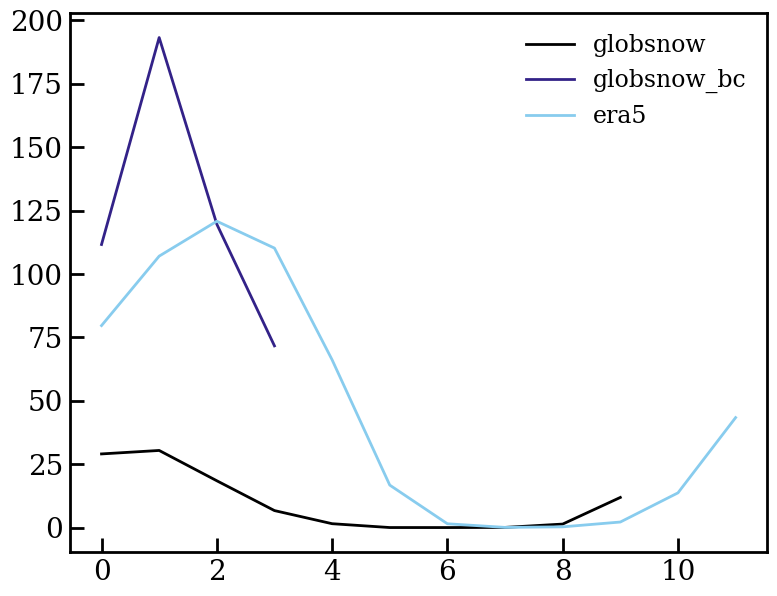

In [71]:
fig,ax=plt.subplots()
ax.plot(monthly_glob, label = 'globsnow')
ax.plot(monthly_bc, label = 'globsnow_bc')
ax.plot(monthly_e5_mm, label = 'era5')
ax.legend()
plt.show()

In [66]:
monthly

<xarray.DataArray 'snw' (month: 12)>
array([ 4.49608536e+01,  6.81660538e+01,  8.77353668e+01,  6.47396851e+01,
        4.65322208e+00,  2.05178309e-04, -7.89346529e-07,  1.06270645e-05,
        3.84207419e-03,  3.10925812e-01,  4.71929455e+00,  2.16064777e+01],
      dtype=float32)
Coordinates:
    lat      float64 61.88
    lon      float64 29.06
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean where land time: mean
    comment:        mo: This includes snow on the canopy of the needleleaf tr...
    long_name:      Surface Snow Amount
    original_name:  mo: land_class_mean((stash: m01s08i236, lbproc: 128), (st...
    standard_name:  surface_snow_amount
    units:          kg m-2

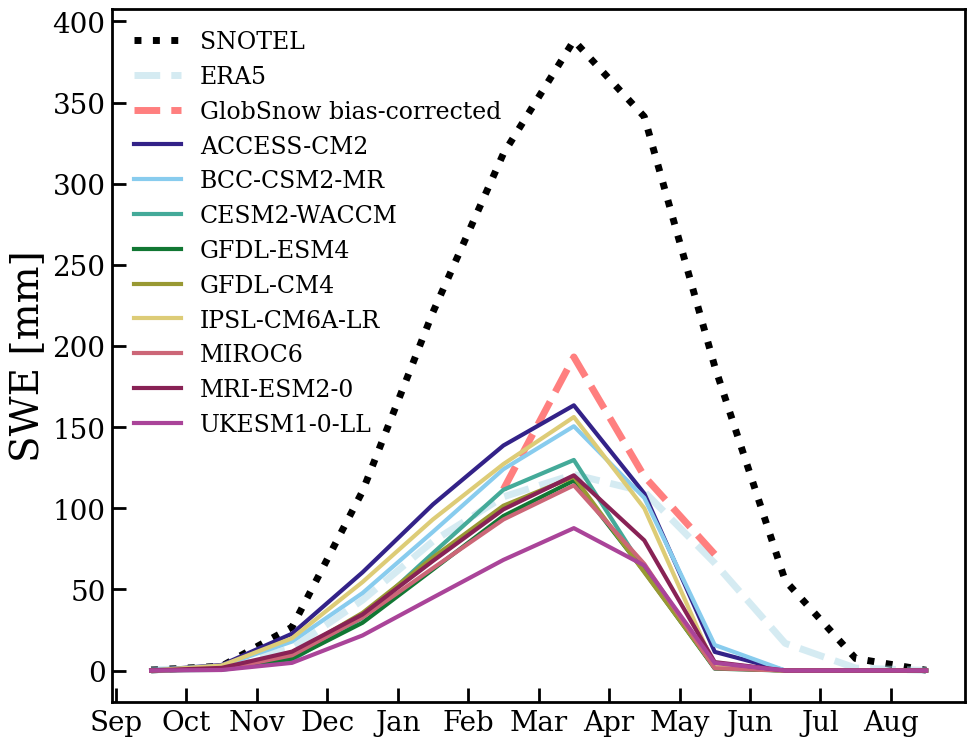

In [74]:
## just the snotel sites ##
months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
nums = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
fig,ax=plt.subplots(figsize=(11,9))
globnums = [ 1,  2,  3,  4,  5,  6,  9, 10, 11, 12]
swe_snotel[swe_snotel <0] = np.nan
snotel_data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
ax.plot(nums, np.roll(snotel_data,4),':', linewidth = 5, alpha = 1, label = 'SNOTEL')
#ax.plot(nums, np.roll(merramonthly,4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5, label = 'MERRA-2')
ax.plot(nums, np.roll(monthly_e5_mm,4), '--', c = "lightblue",linewidth = 5 , alpha = 0.5, label = 'ERA5')
# ax.plot([val + .5 for val in monthly_glob], np.roll(monthly_glob,4), '--', c = "green",linewidth = 5 , alpha = 0.5, label = 'GlobSnow')
ax.plot([5.5,6.5,7.5,8.5], np.roll(monthly_bc,4), '--', c = "red",linewidth = 5 , alpha = 0.5, label = 'GlobSnow bias-corrected')

for key in allnames:
    data = snw_snotel[key][0][0][:]
    monthly = data.groupby(data.month).mean()
    ax.plot(nums, np.roll(monthly,4), label = key, linewidth = 3)
data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
#ax.plot(nums, np.roll(data/2.54,3),'k:', linewidth = 5, alpha = 1)
#ax.plot(nums, np.roll(merramonthly,3)*4 -0.6, '--', c = "darkgray",linewidth = 10 , alpha = 1)

ax.set_xticks(range(0,12))
ax.set_xticklabels(months)
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()
fig.savefig('./figures/fig1.jpg')

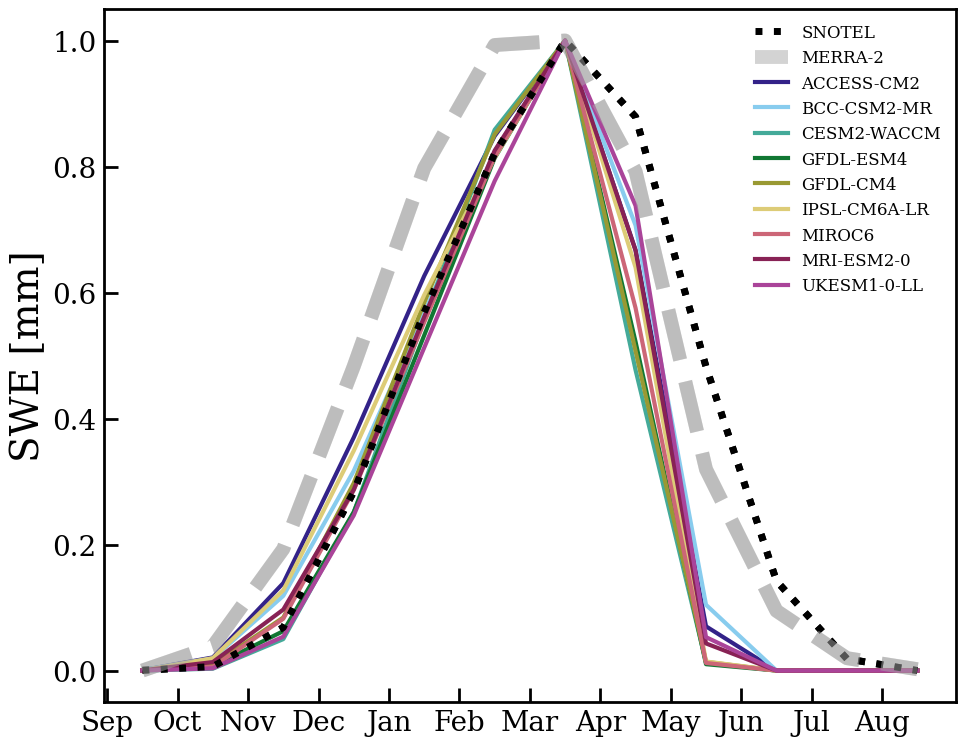

In [22]:

## just the snotel sites ##
def minmax(data):
    return [(val- np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data)) for val in data]


months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
nums = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
fig,ax=plt.subplots(figsize=(11,9))
swe_snotel[swe_snotel <0] = np.nan
snotel_data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
ax.plot(nums, np.roll(minmax(snotel_data.data),4),':',  linewidth = 5, alpha = 1, label = 'SNOTEL')
ax.plot(nums, np.roll(minmax(merramonthly.merra),4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5, label = 'MERRA-2')

for key in allnames:
    data = snw_snotel[key][0][0][:]
    monthly = data.groupby(data.month).mean()
    ax.plot(nums, np.roll(minmax(monthly),4), label = key, linewidth = 3)

ax.plot(nums, np.roll(minmax(snotel_data.data),4),':', color = 'k', linewidth = 5, alpha = 1)
ax.plot(nums, np.roll(minmax(merramonthly.merra),4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5)

ax.set_xticks(range(0,12))
ax.set_xticklabels(months)
ax.set_ylabel(r'SWE [mm]')
ax.legend(loc = 'upper right', fontsize = 12)
plt.show()
fig.savefig('./figures/fig1.jpg')